In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from datasets import load_dataset
import os 


In [2]:
dataset = load_dataset("gsm8k", "main")
train_questions = np.array(dataset["train"]["question"])
train_answers = np.array(dataset["train"]['answer'])

test_questions = np.array(dataset["test"]["question"])
test_answers = np.array(dataset["test"]['answer'])




In [3]:

def get_stats(train_name):
    train_accs_all = []
    perplexities_all = []


    ckpts = sorted([
    f for f in os.listdir("ckpts/"+train_name) if os.path.isdir(os.path.join("ckpts/"+train_name, f))
    ], key=lambda x: int(x.split('-')[1]))
    # print(ckpts)

    for ckpt in ckpts:
        try:
            train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types5_seed2_temp0.8.npy")==0)
            
        except:
            try: 
                train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types50_seed2_temp0.8.npy")==0)
            except: 
                train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types10_seed2_temp0.8.npy")==0)
        train_accs = train_correct.mean(axis=-1)
        train_accs_all.append(train_accs)
        
        perplexities = np.load("ckpts/"+train_name+"/"+ckpt+ "/train_perplexities.npy")
        perplexities_all.append(perplexities)
        
    train_accs_all = np.array(train_accs_all)
    perplexities_all = np.array(perplexities_all)
    
    test_accs_all = []

    for ckpt in ckpts:
        try:
            test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types50_seed2.npy")==0)
        except:
            try:
                test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types50_seed2_temp0.8.npy")==0)
            except:
                try:
                    test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types5_seed2_temp0.8.npy")==0)
                except:
                    test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types20_seed2_temp0.8.npy")==0)
        test_accs_all.append(test_accs)

    test_accs_all = np.array(test_accs_all)
    
    return_dict = {}
    return_dict["train_accs_all"] = train_accs_all
    return_dict["perplexities_all"] = perplexities_all
    return_dict["test_accs_all"] = test_accs_all
    
    return return_dict




def get_ratios2(stats_dict, perp_threshold=-2.4):
    train_accs_all = stats_dict["train_accs_all"]
    perplexities_all = stats_dict["perplexities_all"]
    test_accs_all = stats_dict["test_accs_all"]
    
    memorization_mask = np.ones(train_accs_all.shape)*-1
    accs_all = np.ones(train_accs_all.shape)*-1
    
    for i in range(len(train_accs_all)):

        accs_all[i] =train_accs_all[i]
        
        memorization_mask[i] = (np.log(np.log((perplexities_all[i]))) >= perp_threshold)
    
    
    
    
    unmemorized_acc_cummax = np.array([(accs_all*memorization_mask)[:j+1].max(axis=0) for j in range(len(train_accs_all))])
    
    # print(unmemorized_acc_cummax.shape)
    # print(accs_all.shape)
    unmemorized_acc_cummax = (np.min([unmemorized_acc_cummax, accs_all], axis=0))
    unmemorized_acc_cummax_mean = unmemorized_acc_cummax.mean(axis=1)
    

    avg_test_acc = test_accs_all.mean(axis=-1).mean(axis=1)
    
    
    
    return_dict = {}
    
    
    return_dict["unmemorized_acc_cummax"] = unmemorized_acc_cummax_mean
    return_dict["unmemorized_acc_cummax_all"] = unmemorized_acc_cummax

    return_dict["avg_test_acc"] = avg_test_acc
            
    return return_dict


In [4]:
file_name = "gsm8k_amrith_3epochs_prev{prev{prev{0copies_threshold0.75_1newcopies}}}_lr2e-05_bs128"

In [5]:
stats_dict = get_stats(file_name)
ratio_dict = get_ratios2(stats_dict, perp_threshold=-2.4)

In [6]:
np.save("ckpts/"+file_name+"/unmemorized_acc_cummax_all.npy", ratio_dict['unmemorized_acc_cummax_all'])

In [11]:
(ratio_dict['unmemorized_acc_cummax_all'][-1]<=0.75).mean()#*(18-7)

0.43757527097551185

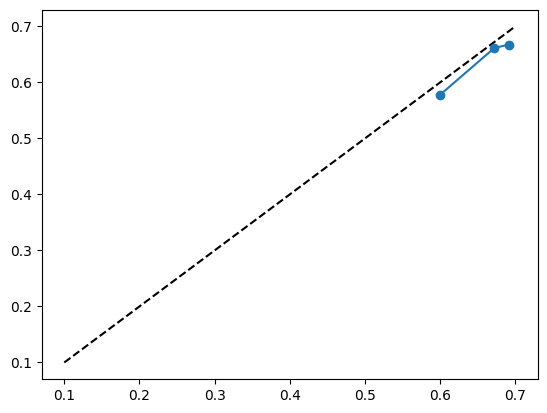

In [79]:
plt.plot([0.1, 0.7], [0.1, 0.7], "k--")

plt.plot(ratio_dict["unmemorized_acc_cummax"], ratio_dict["avg_test_acc"], "o-")

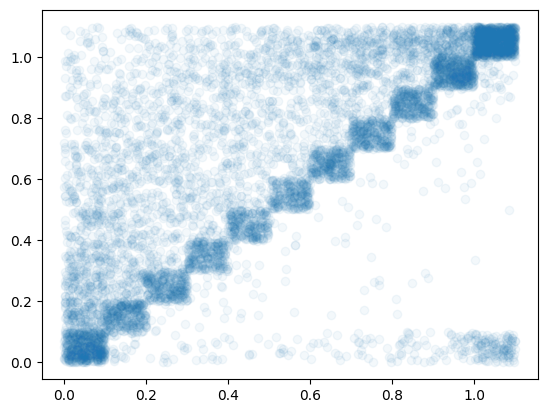

In [150]:


plt.scatter(stats_dict["train_accs_all"][0]+np.random.uniform(0, 0.1, 7473), ratio_dict["unmemorized_acc_cummax_all"][-1]+np.random.uniform(0, 0.1, 7473), alpha=0.05)



In [155]:
(stats_dict["train_accs_all"][0] == ratio_dict["unmemorized_acc_cummax_all"][-1]).mean()

0.6433828449083366

(array([[5.250e+02, 1.520e+02, 1.970e+02, 0.000e+00, 6.900e+01, 9.600e+01,
         3.100e+01, 0.000e+00, 2.900e+01, 5.000e+01],
        [2.200e+01, 3.040e+02, 1.370e+02, 0.000e+00, 5.600e+01, 9.800e+01,
         4.000e+01, 0.000e+00, 4.000e+01, 4.000e+01],
        [2.200e+01, 1.400e+01, 5.860e+02, 0.000e+00, 7.600e+01, 1.730e+02,
         7.800e+01, 0.000e+00, 7.800e+01, 1.370e+02],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [7.000e+00, 3.000e+00, 1.200e+01, 0.000e+00, 2.390e+02, 6.800e+01,
         3.900e+01, 0.000e+00, 3.500e+01, 9.700e+01],
        [2.200e+01, 2.000e+00, 7.000e+00, 0.000e+00, 6.000e+00, 5.670e+02,
         6.700e+01, 0.000e+00, 8.200e+01, 2.570e+02],
        [1.800e+01, 1.000e+00, 5.000e+00, 0.000e+00, 4.000e+00, 6.000e+00,
         2.930e+02, 0.000e+00, 4.000e+01, 1.670e+02],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.

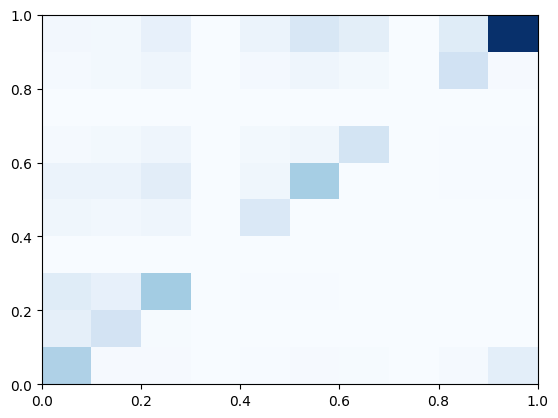

In [147]:
plt.hist2d(stats_dict["train_accs_all"][0], ratio_dict["unmemorized_acc_cummax_all"][-1], cmap="Blues")

In [135]:
ratio_dict["unmemorized_acc_cummax"][-1]

0.7363575538605647

In [143]:
stats_dict["train_accs_all"][0].shape

(7473,)

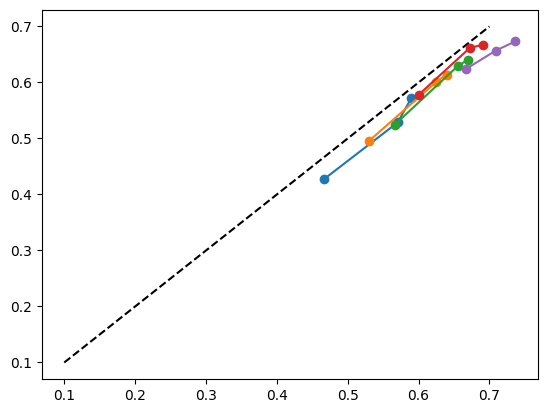

In [15]:
plt.plot([0.1, 0.7], [0.1, 0.7], "k--")
unmemorized_acc_cummax_all_s = []
for num_copies in [0, 1, 3, 7, 15]:

    file_name = f"gsm8k_amrith_3epochs_{num_copies}copies_lr2e-05_bs128"
    

    stats_dict = get_stats(file_name)
    ratio_dict = get_ratios2(stats_dict, perp_threshold=-2.4)
    unmemorized_acc_cummax_all_s.append(ratio_dict["unmemorized_acc_cummax_all"][-1])
    np.save("ckpts/"+file_name+"/unmemorized_acc_cummax_all.npy", ratio_dict["unmemorized_acc_cummax_all"])

    plt.plot(ratio_dict["unmemorized_acc_cummax"], ratio_dict["avg_test_acc"], "o-")  
    
    # stats_dict["train_accs_all"][0]
    # plt.plot(ratio_dict["unmemorized_acc_cummax"], ratio_dict["avg_test_acc"], "o-")  
    
    # plt.hist(ratio_dict["unmemorized_acc_cummax_all"][-1], alpha=0.5, bins = [-0.1, 0.1, 0.3, 0.5, 0.7, 0.9, 1.1], label=f"{num_copies} copies")
    # plt.hist(ratio_dict["unmemorized_acc_cummax_all"][-1], alpha=0.5, bins = np.arange(-0.1, 1.1, 0.1)+0.05, label=f"{num_copies} copies")

In [12]:
unmemorized_acc_cummax_all_s = np.array(unmemorized_acc_cummax_all_s)
import copy
unmemorized_acc_cummax_all_s_shuffle = copy.copy(unmemorized_acc_cummax_all_s)

for row in unmemorized_acc_cummax_all_s_shuffle:
    np.random.shuffle(row)
sorted_idxs = np.argsort(unmemorized_acc_cummax_all_s.mean(axis=0))
sorted_idxs_shuffle = np.argsort(unmemorized_acc_cummax_all_s_shuffle.mean(axis=0))

In [13]:
sorted_array = unmemorized_acc_cummax_all_s[:, sorted_idxs]
sorted_expanded = []

for row in sorted_array:
    for _ in range(1000):
        sorted_expanded.append(row)

sorted_expanded = np.array(sorted_expanded)

In [11]:
sorted = unmemorized_acc_cummax_all_s_shuffle[:, sorted_idxs_shuffle]
sorted_expanded = []

for row in sorted:
    for _ in range(1000):
        sorted_expanded.append(row)

sorted_expanded = np.array(sorted_expanded)

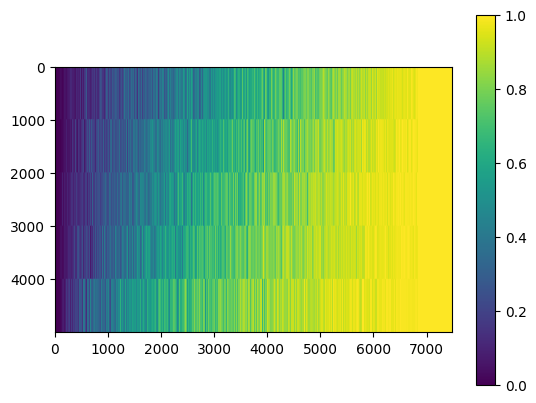

In [14]:
plt.imshow(sorted_expanded)
plt.colorbar() 

In [12]:
ratio_dict

{'unmemorized_acc_cummax': array([0.60030777, 0.67224675, 0.69119497]),
 'unmemorized_acc_cummax_all': array([[1. , 0.9, 0. , ..., 0.8, 0.9, 0.2],
        [1. , 0.9, 0.7, ..., 0.7, 0.7, 0.2],
        [1. , 0.9, 0.4, ..., 0.8, 0.9, 0.2]]),
 'avg_test_acc': array([0.57831691, 0.66156179, 0.66762699])}

In [ ]:
# 1 copy + threshold new -- sweep over thresholds and amount of new data 


# double (2 copies extra)
# half of double (1 copy extra)


# <=0.5
# <=0.75 